In [194]:
import ast
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, hamming_loss,
                             multilabel_confusion_matrix)

In [195]:
root_dir = Path('.')  # Or specify the full path if needed

# List all directories starting with "results_MIL_with_weights_"
result_dirs = sorted(root_dir.glob('results_distilbert_attention_*'), key=lambda x: x.name, reverse=True)

# Ensure there's at least one directory
if result_dirs:
    # Get the latest directory
    latest_dir = result_dirs[0]
    
    # Define the path to the CSV file
    csv_path = latest_dir / 'dev_predictions.csv'
    
    # Load the CSV file
    if csv_path.exists():
        predictions_df = pd.read_csv(csv_path)
        print("File retrieved:", csv_path)
        print(predictions_df.head())
    else:
        print(f"The CSV file does not exist in {latest_dir}")
else:
    print("No result directories found.")

emotion_labels = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]

File retrieved: results_distilbert_attention_2025-02-09_11-25-38/dev_predictions.csv
                      id                                               text  \
0  eng_dev_track_a_00001  Older sister (23 at the time) is a Scumbag Stacy.   
1  eng_dev_track_a_00002  And I laughed like this: garhahagar, because m...   
2  eng_dev_track_a_00003  It overflowed and brown shitty diarrhea water ...   
3  eng_dev_track_a_00004                           Its very dark and foggy.   
4  eng_dev_track_a_00005  Then she tried to, like, have sex with/strangl...   

   anger  fear  joy  sadness  surprise  pred_anger  pred_fear  pred_joy  \
0      1     0    0        0         0           0          0         0   
1      0     1    0        0         0           1          1         0   
2      1     1    0        1         1           1          1         0   
3      0     1    0        0         0           0          1         0   
4      1     1    0        0         1           1          1    

In [196]:
# manual
# csv_path = 'results/validation_predictions.csv'

In [197]:
csv_path

PosixPath('results_distilbert_attention_2025-02-09_11-25-38/dev_predictions.csv')

In [206]:
df

,id,text,anger,fear,joy,sadness,surprise,pred_anger,pred_fear,pred_joy,pred_sadness,pred_surprise,True Labels,Predicted Labels
0,eng_dev_track_a_00001,Older sister (23 at the time) is a Scumbag Stacy.,1,0,0,0,0,0,0,0,0,1,"[1, 0, 0, 0, 0]","[0, 0, 0, 0, 1]"
1,eng_dev_track_a_00002,"And I laughed like this: garhahagar, because m...",0,1,0,0,0,1,1,0,1,0,"[0, 1, 0, 0, 0]","[1, 1, 0, 1, 0]"
2,eng_dev_track_a_00003,It overflowed and brown shitty diarrhea water ...,1,1,0,1,1,1,1,0,1,0,"[1, 1, 0, 1, 1]","[1, 1, 0, 1, 0]"
3,eng_dev_track_a_00004,Its very dark and foggy.,0,1,0,0,0,0,1,0,0,1,"[0, 1, 0, 0, 0]","[0, 1, 0, 0, 1]"
4,eng_dev_track_a_00005,"Then she tried to, like, have sex with/strangl...",1,1,0,0,1,1,1,0,1,1,"[1, 1, 0, 0, 1]","[1, 1, 0, 1, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,eng_dev_track_a_00112,My heart was beating fast from excitement.,0,0,1,0,0,0,1,1,0,0,"[0, 0, 1, 0, 0]","[0, 1, 1, 0, 0]"
112,eng_dev_track_a_00113,A fraying rope stretches down from the rafters.,0,1,0,0,1,0,1,0,1,0,"[0, 1, 0, 0, 1]","[0, 1, 0, 1, 0]"
113,eng_dev_track_a_00114,so i cried my eyes out and did the drawing.,0,0,0,1,0,0,0,0,1,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 1, 0]"
114,eng_dev_track_a_00115,Never been so close to a group ass-wooping in ...,1,1,0,0,1,0,0,1,0,0,"[1, 1, 0, 0, 1]","[0, 0, 1, 0, 0]"


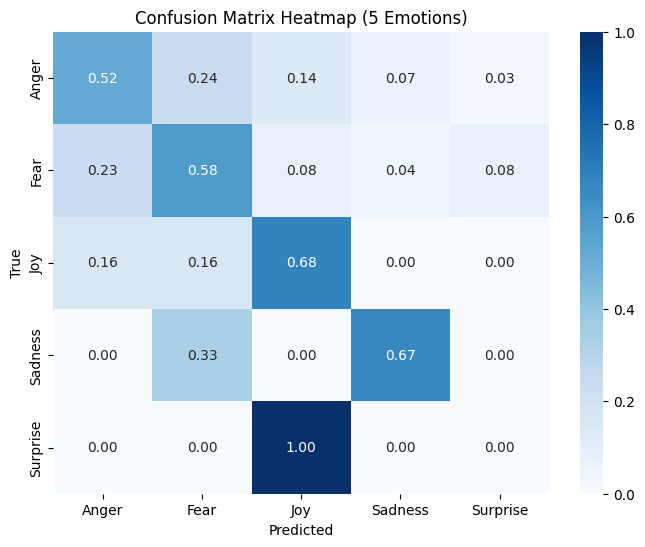

In [198]:
df = pd.read_csv(csv_path)

df["True Labels"] = df["True Labels"].apply(ast.literal_eval)
df["Predicted Labels"] = df["Predicted Labels"].apply(ast.literal_eval)

true_labels = np.array(df["True Labels"].tolist())
pred_labels = np.array(df["Predicted Labels"].tolist())

# TODO: how to calculate for multi-class?
true_classes = true_labels.argmax(axis=1)
pred_classes = pred_labels.argmax(axis=1)

cm = confusion_matrix(true_classes, pred_classes, labels=range(len(emotion_labels)))

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=emotion_labels, 
    yticklabels=emotion_labels
)
plt.title("Confusion Matrix Heatmap (5 Emotions)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

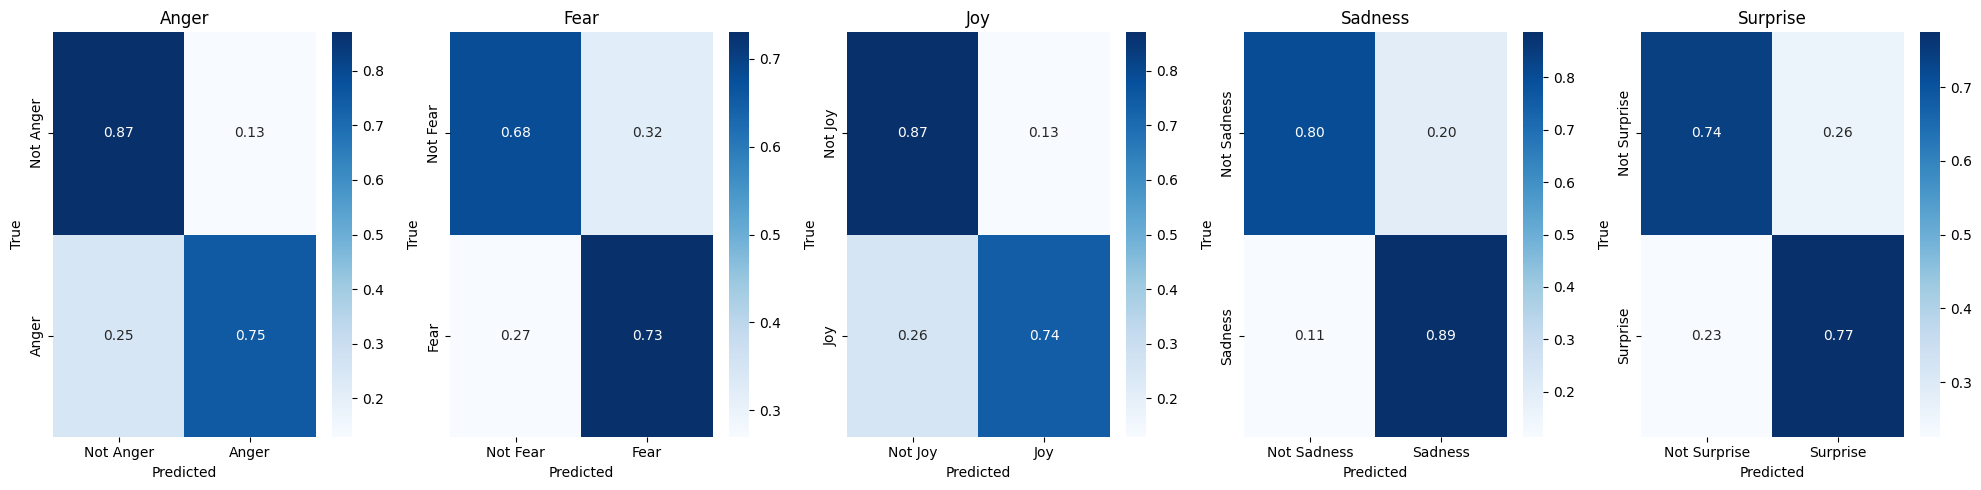

Hamming Loss: 0.20517241379310344
Subset Accuracy: 0.3275862068965517


In [199]:
df = pd.read_csv(csv_path)

df["True Labels"] = df["True Labels"].apply(ast.literal_eval)
df["Predicted Labels"] = df["Predicted Labels"].apply(ast.literal_eval)

true_labels = np.array(df["True Labels"].tolist())
pred_labels = np.array(df["Predicted Labels"].tolist())

# Multilabel confusion matrix
cm_per_class = multilabel_confusion_matrix(true_labels, pred_labels)

# Normalize confusion matrices to range 0 to 1
cm_per_class_normalized = []
for cm in cm_per_class:
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_normalized[np.isnan(cm_normalized)] = 0  # Handle division by zero
    cm_per_class_normalized.append(cm_normalized)

# Plot heatmaps for each class
fig, axes = plt.subplots(1, len(emotion_labels), figsize=(20, 5))
for i, label in enumerate(emotion_labels):
    sns.heatmap(
        cm_per_class_normalized[i],
        annot=True,
        fmt=".2f",  # Display normalized values with 2 decimal places
        cmap="Blues",
        xticklabels=["Not " + label, label],
        yticklabels=["Not " + label, label],
        ax=axes[i],
    )
    axes[i].set_title(label)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")
plt.tight_layout()
plt.show()

# Calculate and display additional metrics
hamming = hamming_loss(true_labels, pred_labels)
subset_acc = accuracy_score(true_labels, pred_labels)

print("Hamming Loss:", hamming)
print("Subset Accuracy:", subset_acc)


In [201]:
# Classification Report
print("\nMultilabel Classification Report:")
for i, label in enumerate(emotion_labels):
    print(f"Label: {label}")
    print(classification_report(true_labels[:, i], pred_labels[:, i], zero_division=0))


Multilabel Classification Report:
Label: Anger
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       100
           1       0.48      0.75      0.59        16

    accuracy                           0.85       116
   macro avg       0.72      0.81      0.75       116
weighted avg       0.89      0.85      0.87       116

Label: Fear
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        53
           1       0.73      0.73      0.73        63

    accuracy                           0.71       116
   macro avg       0.70      0.70      0.70       116
weighted avg       0.71      0.71      0.71       116

Label: Joy
              precision    recall  f1-score   support

           0       0.90      0.87      0.89        85
           1       0.68      0.74      0.71        31

    accuracy                           0.84       116
   macro avg       0.79      0.81      0.80       116
wei

In [202]:
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, hamming_loss,
                             multilabel_confusion_matrix, f1_score)

In [203]:
# f1 macro avg
f1_macro_avg = f1_score(true_labels, pred_labels, average='macro')

In [204]:
f1_macro_avg

0.6805382151723615

In [193]:
f1_scores = {
    emotion: f1_score(true_labels[:, i], pred_labels[:, i], average="binary")
    for i, emotion in enumerate(emotion_labels)
}

print("F1 Scores by Emotion:")
for emotion, score in f1_scores.items():
    print(f"{emotion}: {score:.2f}")

average_f1 = np.mean(list(f1_scores.values()))
print(f"\nAverage F1 Score: {average_f1:.2f}")

F1 Scores by Emotion:
Anger: 0.67
Fear: 0.72
Joy: 0.70
Sadness: 0.75
Surprise: 0.62

Average F1 Score: 0.69


In [134]:
from sklearn.metrics import f1_score

# Group by 'comment' column
grouped = df.groupby('comment')

# Calculate F1 score with macro average for each group
f1_scores_by_comment = {}
for comment, group in grouped:
    true_labels_group = np.array(group["True Labels"].tolist())
    pred_labels_group = np.array(group["Predicted Labels"].tolist())
    f1_macro = f1_score(true_labels_group, pred_labels_group, average='macro')
    f1_scores_by_comment[comment] = f1_macro

# Print the F1 scores
for comment, score in f1_scores_by_comment.items():
    print(f"Comment: {comment}, F1 Score (Macro Avg): {score:.2f}")

KeyError: 'comment'